# Kaggle соревнование

In [7]:
!pip3 install -r requirements.txt
# brew install lightgbm

In [2]:
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_log_error as RMSLE
from sklearn.ensemble import VotingRegressor, StackingRegressor
from openfe import OpenFE, transform
from optuna.samplers import TPESampler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
import optuna

import warnings
warnings.filterwarnings("ignore")

/home/jovyan/3dgen/users/danil/envs/exp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set_style(style="darkgrid")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
df0 = pd.read_csv("train.csv", delimiter=",")
X_val = pd.read_csv("test.csv", delimiter=",")
df0 = df0.rename(columns={
    "Whole weight": "Whole_weight",
    "Whole weight.1": "Shucked_weight",
    "Whole weight.2": "Viscera_weight",
    "Shell weight": "Shell_weight"
    })

X_val = X_val.rename(columns={
    "Whole weight": "Whole_weight",
    "Whole weight.1": "Shucked_weight",
    "Whole weight.2": "Viscera_weight",
    "Shell weight": "Shell_weight"
    })

df = df0.copy()
df["Rings"] = np.log1p(df["Rings"])
non_cat_features = ["Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight"]
cat_features = ["Sex"]

df_order_enc = df.drop(columns=["id", "Sex"])
df_order_enc["Sex"] = np.where(df["Sex"] == "M", 1, np.where(df["Sex"] == "I", 0, -1))

Q1, Q3 = df[non_cat_features].quantile(0.25), df[non_cat_features].quantile(0.75)
IQR = Q3 - Q1
top_lim, bottom_lim = Q3 + whis * IQR, Q1 - whis * IQR

mask = (df[non_cat_features] >= bottom_lim) & (df[non_cat_features] <= top_lim)
df = df[mask.all(axis=1)]

print(f"В датасете осталось {len(df)} строк")

non_cat_features = ["Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight"]
cat_features = ["Sex"]

df0

В датасете осталось 87266 строк


,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...,...
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6


In [8]:
X_train, y_train = df[non_cat_features + cat_features], df["Rings"]

### Генерация и отбор признаков.

In [9]:
ofe = OpenFE()
features = ofe.fit(data=X_train, label=y_train, n_jobs=4, seed=RANDOM_SEED, categorical_features=cat_features)
X_train_FE, X_valid_FE = transform(X_train, X_val, features, n_jobs=4)
X_train_FE

The number of candidate features is 266
Start stage I selection.


  0%|          | 0/16 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 255[LightGBM] [Info] Total Bins 88

[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

  6%|▋         | 1/16 [00:00<00:14,  1.03it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Total Bins 255[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1[LightGBM] [Warning] No further splits 

 25%|██▌       | 4/16 [00:01<00:03,  3.97it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No f

 31%|███▏      | 5/16 [00:01<00:04,  2.74it/s]


[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Total Bins 34


[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

 44%|████▍     | 7/16 [00:02<00:02,  4.08it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 56%|█████▋    | 9/16 [00:02<00:01,  3.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 0[LightGBM] [Warnin

 69%|██████▉   | 11/16 [00:02<00:01,  4.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to rem

 75%|███████▌  | 12/16 [00:02<00:00,  5.48it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

 81%|████████▏ | 13/16 [00:03<00:00,  4.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Total Bins 4

[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1[LightGBM] [Info] Total Bins 255

[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 88%|████████▊ | 14/16 [00:03<00:00,  4.21it/s]


[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threa

100%|██████████| 16/16 [00:04<00:00,  3.68it/s]


88 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


  0%|          | 0/15 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to

  7%|▋         | 1/15 [00:02<00:34,  2.43s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to

 13%|█▎        | 2/15 [00:02<00:15,  1.20s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


 20%|██        | 3/15 [00:02<00:08,  1.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 46[LightGBM] [Info] Total Bins 255

[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1



 27%|██▋       | 4/15 [00:03<00:05,  1.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to

 33%|███▎      | 5/15 [00:05<00:10,  1.06s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

 47%|████▋     | 7/15 [00:05<00:05,  1.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


 53%|█████▎    | 8/15 [00:05<00:03,  1.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to

 60%|██████    | 9/15 [00:07<00:05,  1.09it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` t

 67%|██████▋   | 10/15 [00:08<00:03,  1.33it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

 73%|███████▎  | 11/15 [00:08<00:02,  1.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` t

 80%|████████  | 12/15 [00:09<00:01,  1.59it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

 93%|█████████▎| 14/15 [00:10<00:00,  1.57it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


The number of remaining candidate features is 177
Start stage II selection.


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


Finish data processing.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35945
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 185


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex,autoFE_f_0,autoFE_f_1,...,autoFE_f_167,autoFE_f_168,autoFE_f_169,autoFE_f_170,autoFE_f_171,autoFE_f_172,autoFE_f_173,autoFE_f_174,autoFE_f_175,autoFE_f_176
openfe_index,,,,,,,,,,,,,,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,F,2.291667,0.036000,...,0.2650,3.0,0.107912,0.4205,0.1465,0.2050,0.057600,0.455,0.3285,0.577813
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,F,1.968750,0.046400,...,0.2500,3.0,0.209764,0.3600,0.2765,0.1835,0.102400,0.445,0.4580,0.562337
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,M,2.380000,0.037500,...,0.2650,3.0,0.141000,0.4205,0.2055,0.2050,0.062500,0.455,0.3755,0.577813
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,I,2.810127,0.025675,...,0.1955,3.0,0.136530,0.3950,0.1600,0.1475,0.039006,0.405,0.3695,0.525215
5,0.610,0.480,0.170,1.2010,0.5335,0.3135,0.3085,F,1.977310,0.052445,...,0.3300,3.0,0.284622,0.5260,0.3135,0.2475,0.095172,0.475,0.5335,0.609823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,M,7.444444,0.003375,...,0.0435,3.0,0.004692,0.1065,0.0370,0.0315,0.002025,0.230,0.0685,0.315499
90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,M,2.312500,0.036000,...,0.2650,3.0,0.149382,0.4205,0.1815,0.2050,0.057600,0.455,0.3865,0.577813
90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,I,5.337423,0.007743,...,0.0800,3.0,0.022801,0.3370,0.0785,0.0575,0.006642,0.290,0.1510,0.387742


In [10]:
cols = X_train_FE.columns
num_cols = X_train_FE._get_numeric_data().columns

feature_cols = list(set(cols) - set(num_cols))
feature_cols.remove("Sex")

X_train_FE = X_train_FE.drop(columns=feature_cols, axis=1)
X_valid_FE = X_valid_FE.drop(columns=feature_cols, axis=1)

X_train_FE[num_cols] = X_train_FE[num_cols].astype(float)
X_valid_FE[num_cols] = X_valid_FE[num_cols].astype(float)

In [12]:
X_train_CVFE, X_test_CVFE, y_train_CV, y_test_CV = (X_train_FE, None, y_train, None)

In [15]:
catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    cat_features=cat_features,
).fit(X_train_CVFE, y_train_CV)

Learning rate set to 0.082953
0:	learn: 0.2563154	total: 85.1ms	remaining: 1m 24s
1:	learn: 0.2440333	total: 102ms	remaining: 51s
2:	learn: 0.2332276	total: 119ms	remaining: 39.5s
3:	learn: 0.2236233	total: 134ms	remaining: 33.4s
4:	learn: 0.2150418	total: 153ms	remaining: 30.4s
5:	learn: 0.2073273	total: 169ms	remaining: 27.9s
6:	learn: 0.2003230	total: 184ms	remaining: 26.1s
7:	learn: 0.1941999	total: 198ms	remaining: 24.6s
8:	learn: 0.1888617	total: 212ms	remaining: 23.4s
9:	learn: 0.1841697	total: 228ms	remaining: 22.5s
10:	learn: 0.1799296	total: 240ms	remaining: 21.6s
11:	learn: 0.1763336	total: 253ms	remaining: 20.8s
12:	learn: 0.1731394	total: 265ms	remaining: 20.1s
13:	learn: 0.1704078	total: 276ms	remaining: 19.4s
14:	learn: 0.1678261	total: 286ms	remaining: 18.8s
15:	learn: 0.1657164	total: 296ms	remaining: 18.2s
16:	learn: 0.1638142	total: 307ms	remaining: 17.7s
17:	learn: 0.1620743	total: 316ms	remaining: 17.3s
18:	learn: 0.1605935	total: 326ms	remaining: 16.8s
19:	learn: 

,col_name,shap_importance
11,autoFE_f_3,0.031291
16,autoFE_f_8,0.024364
10,autoFE_f_2,0.018363
13,autoFE_f_5,0.017968
25,autoFE_f_17,0.015606
...,...,...
157,autoFE_f_150,0.000148
178,autoFE_f_171,0.000145
173,autoFE_f_166,0.0001
163,autoFE_f_156,0.0


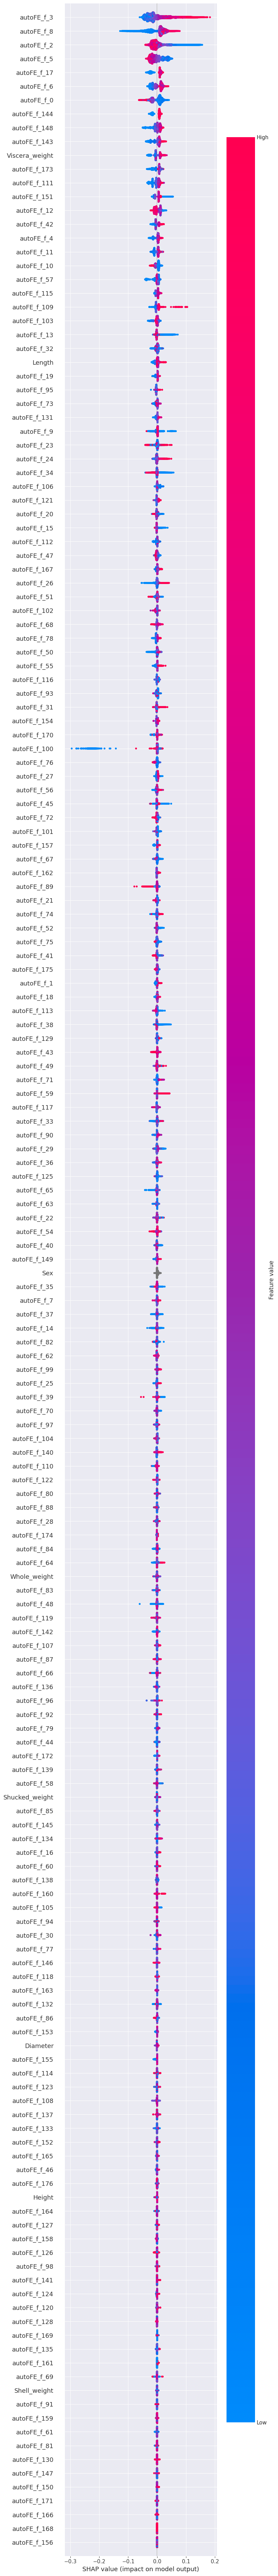

In [16]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(Pool(X_valid_FE.drop(columns=["id"]), cat_features=cat_features))
shap.summary_plot(shap_test, X_valid_FE.drop(columns=["id"]), max_display=X_valid_FE.shape[1], show=False)


shap_sum = np.abs(shap_test).mean(axis=0)
importance_df = pd.DataFrame([X_train_FE.columns.to_list(), list(shap_sum)]).T
importance_df.columns = ["col_name", "shap_importance"]
importance_df = importance_df.sort_values("shap_importance", ascending=False)
importance_df

In [17]:
# cutoff_ind = importance_df.index[importance_df["col_name"] == "autoFE_f_57"].to_list()[0]
cutoff_ind = 40
importance_df = importance_df[:cutoff_ind]
cutoff_ind

40

In [18]:
X_train_CVFE_proc = X_train_CVFE[importance_df["col_name"]]
X_valid_FE_proc = X_valid_FE[importance_df["col_name"].to_list() + ["id"]]

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    # cat_features=["Sex"]
).fit(X_train_CVFE_proc, y_train_CV)

Learning rate set to 0.082953
0:	learn: 0.2564178	total: 8.31ms	remaining: 8.3s
1:	learn: 0.2442719	total: 14.1ms	remaining: 7.04s
2:	learn: 0.2333134	total: 20.1ms	remaining: 6.69s
3:	learn: 0.2237459	total: 26.2ms	remaining: 6.53s
4:	learn: 0.2150563	total: 32ms	remaining: 6.36s
5:	learn: 0.2073157	total: 38ms	remaining: 6.29s
6:	learn: 0.2002107	total: 43.6ms	remaining: 6.18s
7:	learn: 0.1941655	total: 49.4ms	remaining: 6.13s
8:	learn: 0.1887036	total: 54.8ms	remaining: 6.03s
9:	learn: 0.1840156	total: 60.1ms	remaining: 5.95s
10:	learn: 0.1797214	total: 65.5ms	remaining: 5.88s
11:	learn: 0.1760200	total: 70.5ms	remaining: 5.81s
12:	learn: 0.1728774	total: 75.4ms	remaining: 5.72s
13:	learn: 0.1700650	total: 80.2ms	remaining: 5.65s
14:	learn: 0.1676161	total: 84.4ms	remaining: 5.54s
15:	learn: 0.1653694	total: 88.8ms	remaining: 5.46s
16:	learn: 0.1635295	total: 92.9ms	remaining: 5.37s
17:	learn: 0.1618153	total: 97.1ms	remaining: 5.3s
18:	learn: 0.1602900	total: 101ms	remaining: 5.22s

In [19]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(X_valid_FE_proc.drop(columns=["id"]))
features_to_delete = set(["autoFE_f_" + str(feature_num) for feature_num in [117, 158, 16, 38, 9, 109, 20, 130, 30, 80, 121, 74, 34,
                                                                             10, 100, 2, 0]] + [])
importance_df = importance_df[~importance_df["col_name"].isin(features_to_delete)]
print(len(importance_df))
importance_df

32


,col_name,shap_importance
11,autoFE_f_3,0.031291
16,autoFE_f_8,0.024364
13,autoFE_f_5,0.017968
25,autoFE_f_17,0.015606
14,autoFE_f_6,0.014647
151,autoFE_f_144,0.011825
155,autoFE_f_148,0.010445
150,autoFE_f_143,0.010392
6,Shell_weight,0.010283
180,autoFE_f_173,0.010272


In [20]:
X_train_CVFE_proc = X_train_CVFE[importance_df["col_name"]]
X_valid_FE_proc = X_valid_FE[importance_df["col_name"].to_list() + ["id"]]

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    # cat_features=["Sex"]
).fit(X_train_CVFE_proc, y_train_CV)

Learning rate set to 0.082953
0:	learn: 0.2565350	total: 7.27ms	remaining: 7.26s
1:	learn: 0.2442644	total: 12.6ms	remaining: 6.27s
2:	learn: 0.2331902	total: 18.3ms	remaining: 6.09s
3:	learn: 0.2235500	total: 23.7ms	remaining: 5.9s
4:	learn: 0.2148858	total: 29ms	remaining: 5.78s
5:	learn: 0.2070378	total: 34.4ms	remaining: 5.7s
6:	learn: 0.2002726	total: 39.5ms	remaining: 5.6s
7:	learn: 0.1940787	total: 44.8ms	remaining: 5.56s
8:	learn: 0.1888443	total: 50.3ms	remaining: 5.54s
9:	learn: 0.1841641	total: 55.7ms	remaining: 5.51s
10:	learn: 0.1799444	total: 61.3ms	remaining: 5.51s
11:	learn: 0.1762552	total: 66.4ms	remaining: 5.47s
12:	learn: 0.1730231	total: 71.2ms	remaining: 5.4s
13:	learn: 0.1701576	total: 76.2ms	remaining: 5.36s
14:	learn: 0.1677039	total: 81.2ms	remaining: 5.33s
15:	learn: 0.1655128	total: 85.9ms	remaining: 5.28s
16:	learn: 0.1636559	total: 90.6ms	remaining: 5.24s
17:	learn: 0.1619443	total: 95.5ms	remaining: 5.21s
18:	learn: 0.1604405	total: 100ms	remaining: 5.18s

357:	learn: 0.1429570	total: 1.19s	remaining: 2.13s
358:	learn: 0.1429454	total: 1.19s	remaining: 2.13s
359:	learn: 0.1429342	total: 1.19s	remaining: 2.12s
360:	learn: 0.1429282	total: 1.2s	remaining: 2.12s
361:	learn: 0.1429056	total: 1.2s	remaining: 2.11s
362:	learn: 0.1428977	total: 1.2s	remaining: 2.11s
363:	learn: 0.1428813	total: 1.21s	remaining: 2.11s
364:	learn: 0.1428708	total: 1.21s	remaining: 2.1s
365:	learn: 0.1428568	total: 1.21s	remaining: 2.1s
366:	learn: 0.1428428	total: 1.22s	remaining: 2.1s
367:	learn: 0.1428311	total: 1.22s	remaining: 2.09s
368:	learn: 0.1428211	total: 1.22s	remaining: 2.09s
369:	learn: 0.1428041	total: 1.23s	remaining: 2.09s
370:	learn: 0.1427924	total: 1.23s	remaining: 2.08s
371:	learn: 0.1427793	total: 1.23s	remaining: 2.08s
372:	learn: 0.1427686	total: 1.23s	remaining: 2.08s
373:	learn: 0.1427535	total: 1.24s	remaining: 2.07s
374:	learn: 0.1427403	total: 1.24s	remaining: 2.07s
375:	learn: 0.1427223	total: 1.24s	remaining: 2.06s
376:	learn: 0.1427

In [22]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(X_valid_FE_proc.drop(columns=["id"]))
features_to_delete.update(set(["autoFE_f_" + str(feature_num) for feature_num in [126, 184, 29, 17, 141]] + []))
importance_df = importance_df[~importance_df["col_name"].isin(features_to_delete)]
print(len(importance_df))
importance_df

31


,col_name,shap_importance
11,autoFE_f_3,0.031291
16,autoFE_f_8,0.024364
13,autoFE_f_5,0.017968
14,autoFE_f_6,0.014647
151,autoFE_f_144,0.011825
155,autoFE_f_148,0.010445
150,autoFE_f_143,0.010392
6,Shell_weight,0.010283
180,autoFE_f_173,0.010272
118,autoFE_f_111,0.008998


In [23]:
X_train_CVFE_proc = X_train_CVFE[importance_df["col_name"]]
X_valid_FE_proc = X_valid_FE[importance_df["col_name"].to_list() + ["id"]]

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
).fit(X_train_CVFE_proc, y_train_CV)

Learning rate set to 0.082953
0:	learn: 0.2564006	total: 7.53ms	remaining: 7.52s
1:	learn: 0.2441802	total: 13.4ms	remaining: 6.68s
2:	learn: 0.2330993	total: 19.8ms	remaining: 6.59s
3:	learn: 0.2235153	total: 25.6ms	remaining: 6.39s
4:	learn: 0.2150189	total: 31.7ms	remaining: 6.32s
5:	learn: 0.2070884	total: 37.6ms	remaining: 6.23s
6:	learn: 0.2002136	total: 43.1ms	remaining: 6.11s
7:	learn: 0.1941664	total: 49ms	remaining: 6.07s
8:	learn: 0.1887903	total: 54.7ms	remaining: 6.02s
9:	learn: 0.1839787	total: 60.1ms	remaining: 5.95s
10:	learn: 0.1798869	total: 65.8ms	remaining: 5.91s
11:	learn: 0.1761843	total: 71.7ms	remaining: 5.9s
12:	learn: 0.1730072	total: 77.3ms	remaining: 5.87s
13:	learn: 0.1702121	total: 82.9ms	remaining: 5.83s
14:	learn: 0.1677159	total: 88ms	remaining: 5.78s
15:	learn: 0.1656000	total: 93.3ms	remaining: 5.74s
16:	learn: 0.1636078	total: 98.1ms	remaining: 5.67s
17:	learn: 0.1619140	total: 103ms	remaining: 5.6s
18:	learn: 0.1604686	total: 107ms	remaining: 5.53s


In [25]:
class ParamsOptimizer:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    

    def objective(self, trial):
        catboost_params = {
            "verbose": False,
            "iterations": 1000,
            "loss_function":"RMSE",
            "random_state": RANDOM_SEED,
            "depth": trial.suggest_int("depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.01, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 80),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "l2_leaf_reg":  trial.suggest_float("l2_leaf_reg", 0, 1),
        }
        
        return self.fit(catboost_params)

    def fit(self, params):

        mskf = KFold(n_splits=10, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, y_valid = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            model = CatBoostRegressor(**params)
            model.fit(X_train, y_train)
        

            valid_preds = model.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds

        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))

        return oof_score

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize", sampler=TPESampler(multivariate=True, n_startup_trials=n_trials), pruner=optuna.pruners.MedianPruner())
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params


In [27]:
catboost_optimizer = ParamsOptimizer(X_train=X_train_CVFE_proc, y_train=y_train_CV)
catboost_best_params = catboost_optimizer.optimize(n_trials=50)
catboost_best_params

[I 2024-12-08 16:25:46,929] A new study created in memory with name: no-name-85901cd6-1776-479c-963c-2d8da418a333
[I 2024-12-08 16:27:14,815] Trial 3 finished with value: 0.14883620839890563 and parameters: {'depth': 3, 'subsample': 0.2679266231776237, 'min_data_in_leaf': 62, 'colsample_bylevel': 0.7275929749685185, 'learning_rate': 0.018398272345343747, 'l2_leaf_reg': 0.9759670770408351}. Best is trial 3 with value: 0.14883620839890563.
[I 2024-12-08 16:27:23,897] Trial 1 finished with value: 0.14717135831723802 and parameters: {'depth': 4, 'subsample': 0.34244847983954224, 'min_data_in_leaf': 77, 'colsample_bylevel': 0.3295369028761627, 'learning_rate': 0.05399040824788479, 'l2_leaf_reg': 0.8495700816722197}. Best is trial 1 with value: 0.14717135831723802.
[I 2024-12-08 16:28:50,088] Trial 2 finished with value: 0.16008494213715477 and parameters: {'depth': 8, 'subsample': 0.3308212561754371, 'min_data_in_leaf': 25, 'colsample_bylevel': 0.34919671202576824, 'learning_rate': 0.001566

Best trial:
  Value:  0.14666945719703323
  Params: 
    depth: 8
    subsample: 0.3424109565019256
    min_data_in_leaf: 65
    colsample_bylevel: 0.6986855168783912
    learning_rate: 0.04807194517450657
    l2_leaf_reg: 0.8054263459481451


{'depth': 8,
 'subsample': 0.3424109565019256,
 'min_data_in_leaf': 65,
 'colsample_bylevel': 0.6986855168783912,
 'learning_rate': 0.04807194517450657,
 'l2_leaf_reg': 0.8054263459481451}

In [28]:
catboost_model = CatBoostRegressor(**catboost_best_params).fit(X_train_CVFE_proc, y_train_CV)

0:	learn: 0.2618468	total: 11.2ms	remaining: 11.2s
1:	learn: 0.2541271	total: 24.8ms	remaining: 12.4s
2:	learn: 0.2470571	total: 36.8ms	remaining: 12.2s
3:	learn: 0.2402761	total: 48.5ms	remaining: 12.1s
4:	learn: 0.2338948	total: 61ms	remaining: 12.1s
5:	learn: 0.2279281	total: 72.5ms	remaining: 12s
6:	learn: 0.2222687	total: 84.3ms	remaining: 12s
7:	learn: 0.2169662	total: 95.8ms	remaining: 11.9s
8:	learn: 0.2121256	total: 107ms	remaining: 11.8s
9:	learn: 0.2076360	total: 118ms	remaining: 11.6s
10:	learn: 0.2034599	total: 130ms	remaining: 11.7s
11:	learn: 0.1995306	total: 140ms	remaining: 11.6s
12:	learn: 0.1958585	total: 151ms	remaining: 11.5s
13:	learn: 0.1924223	total: 163ms	remaining: 11.5s
14:	learn: 0.1892779	total: 175ms	remaining: 11.5s
15:	learn: 0.1862102	total: 188ms	remaining: 11.6s
16:	learn: 0.1834854	total: 201ms	remaining: 11.6s
17:	learn: 0.1809126	total: 212ms	remaining: 11.6s
18:	learn: 0.1785786	total: 224ms	remaining: 11.6s
19:	learn: 0.1764229	total: 236ms	remai

In [29]:
class LightGBMOptimizer:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    

    def objective(self, trial):

        lightboost_params = {
            "max_depth": trial.suggest_int("max_depth", 2, 13),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 50, 2500),
            "boosting_type": "gbdt",
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 0, 1),
            "lambda_l2": trial.suggest_float("lambda_l2", 0, 1),
            "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
            "max_bin": trial.suggest_int("max_bin", 10, 1000),
            "random_state": 42,
            "metric": "rmse",
            "top_rate": trial.suggest_float("top_rate", 0.1, 0.5),
            "other_rate": trial.suggest_float("other_rate", 0.1, 0.5),
            "max_delta_step": trial.suggest_float("max_delta_step", 0, 1),
            "verbosity": -1,
        }
        
        return self.fit(lightboost_params)

    def fit(self, params):

        mskf = KFold(n_splits=10, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, y_valid = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            lightgbm_model = LGBMRegressor(**params)
            lightgbm_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stopping(100)])

            valid_preds = lightgbm_model.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds

        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))

        return oof_score

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize", sampler=TPESampler(multivariate=True, n_startup_trials=n_trials), pruner=optuna.pruners.MedianPruner())
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params

In [30]:
lightgbm_optimizer = LightGBMOptimizer(X_train=X_train_CVFE_proc, y_train=y_train_CV)
lightgbm_best_params = lightgbm_optimizer.optimize(n_trials=50)

lightgbm_best_params

[I 2024-12-08 16:29:30,919] A new study created in memory with name: no-name-97df0394-4145-48cd-b409-3e1b26ee9f48


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[313]	valid_0's rmse: 0.211241
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[313]	valid_0's rmse: 0.20256
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 0.149192
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[313]	valid_0's rmse: 0.210368
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[313]	valid_0's rmse: 0.211103
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:


[I 2024-12-08 16:29:58,807] Trial 2 finished with value: 0.20721627734316228 and parameters: {'max_depth': 3, 'num_leaves': 122, 'learning_rate': 0.0017494913827662704, 'n_estimators': 313, 'min_child_samples': 72, 'feature_fraction': 0.29497068351721895, 'subsample': 0.6761142876560959, 'colsample_bytree': 0.7097767852044244, 'lambda_l1': 0.017672362627750626, 'lambda_l2': 0.02660131348969641, 'min_split_gain': 0.5823340591759095, 'max_bin': 95, 'top_rate': 0.2192803881953644, 'other_rate': 0.2479544260511597, 'max_delta_step': 0.7921397660004069}. Best is trial 2 with value: 0.20721627734316228.


Did not meet early stopping. Best iteration is:
[313]	valid_0's rmse: 0.206285
Early stopping, best iteration is:
[205]	valid_0's rmse: 0.150991
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 0.146116
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 0.147266
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	valid_0's rmse: 0.151409
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 0.147742
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	valid_0's rmse: 0.143382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2091]	valid_0's 

[I 2024-12-08 16:30:35,996] Trial 3 finished with value: 0.14782802006270293 and parameters: {'max_depth': 10, 'num_leaves': 230, 'learning_rate': 0.015042721753980378, 'n_estimators': 292, 'min_child_samples': 14, 'feature_fraction': 0.3211643833058163, 'subsample': 0.6626499551171046, 'colsample_bytree': 0.7021201684751074, 'lambda_l1': 0.5432032824987726, 'lambda_l2': 0.35018442628987745, 'min_split_gain': 0.32946427670025213, 'max_bin': 516, 'top_rate': 0.3852183526087739, 'other_rate': 0.168983213754838, 'max_delta_step': 0.4721552673548616}. Best is trial 3 with value: 0.14782802006270293.


Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 0.148469
Early stopping, best iteration is:
[216]	valid_0's rmse: 0.146227
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[271]	valid_0's rmse: 0.145492
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2382]	valid_0's rmse: 0.14351
Training until validation scores don't improve for 100 rounds


[I 2024-12-08 16:30:48,310] Trial 0 finished with value: 0.14677702294123499 and parameters: {'max_depth': 13, 'num_leaves': 208, 'learning_rate': 0.029453966122797114, 'n_estimators': 1956, 'min_child_samples': 10, 'feature_fraction': 0.6063888468224162, 'subsample': 0.7667479320351935, 'colsample_bytree': 0.94183409655418, 'lambda_l1': 0.9060538577415691, 'lambda_l2': 0.7609368100964029, 'min_split_gain': 0.11674769612038349, 'max_bin': 600, 'top_rate': 0.2792888107920114, 'other_rate': 0.21947503158624382, 'max_delta_step': 0.4599599580430338}. Best is trial 0 with value: 0.14677702294123499.


Early stopping, best iteration is:
[201]	valid_0's rmse: 0.145878
Early stopping, best iteration is:
[2076]	valid_0's rmse: 0.152084
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2093]	valid_0's rmse: 0.144236
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2382]	valid_0's rmse: 0.144573
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2066]	valid_0's rmse: 0.149052
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2382]	valid_0's rmse: 0.149187
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2148]	valid_0's rmse: 0.151633
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2381]	valid_0's rmse: 0.147676
Training until validation scores don't improve for 100

[I 2024-12-08 16:31:37,001] Trial 1 finished with value: 0.14865383857795617 and parameters: {'max_depth': 11, 'num_leaves': 11, 'learning_rate': 0.00248119937175102, 'n_estimators': 2300, 'min_child_samples': 55, 'feature_fraction': 0.6440522724074118, 'subsample': 0.602868708232035, 'colsample_bytree': 0.986489970088184, 'lambda_l1': 0.8710741141682482, 'lambda_l2': 0.7734958123532762, 'min_split_gain': 0.7123662695431314, 'max_bin': 866, 'top_rate': 0.37735018571467094, 'other_rate': 0.38341522418184115, 'max_delta_step': 0.9907700538488189}. Best is trial 0 with value: 0.14677702294123499.


Early stopping, best iteration is:
[2067]	valid_0's rmse: 0.148058
Did not meet early stopping. Best iteration is:
[2380]	valid_0's rmse: 0.148392
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2381]	valid_0's rmse: 0.146602
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2380]	valid_0's rmse: 0.151261
Training until validation scores don't improve for 100 rounds


[I 2024-12-08 16:31:52,733] Trial 4 finished with value: 0.14763091960923322 and parameters: {'max_depth': 9, 'num_leaves': 131, 'learning_rate': 0.004305122545567651, 'n_estimators': 2382, 'min_child_samples': 65, 'feature_fraction': 0.21933596999908278, 'subsample': 0.7738574515876577, 'colsample_bytree': 0.9955551788208883, 'lambda_l1': 0.8528855303711947, 'lambda_l2': 0.8314328118384215, 'min_split_gain': 0.2606645313488368, 'max_bin': 492, 'top_rate': 0.28558127384365833, 'other_rate': 0.47610420422691657, 'max_delta_step': 0.8020428952617327}. Best is trial 0 with value: 0.14677702294123499.


Did not meet early stopping. Best iteration is:
[2382]	valid_0's rmse: 0.148537
Best trial:
  Value:  0.14677702294123499
  Params: 
    max_depth: 13
    num_leaves: 208
    learning_rate: 0.029453966122797114
    n_estimators: 1956
    min_child_samples: 10
    feature_fraction: 0.6063888468224162
    subsample: 0.7667479320351935
    colsample_bytree: 0.94183409655418
    lambda_l1: 0.9060538577415691
    lambda_l2: 0.7609368100964029
    min_split_gain: 0.11674769612038349
    max_bin: 600
    top_rate: 0.2792888107920114
    other_rate: 0.21947503158624382
    max_delta_step: 0.4599599580430338


{'max_depth': 13,
 'num_leaves': 208,
 'learning_rate': 0.029453966122797114,
 'n_estimators': 1956,
 'min_child_samples': 10,
 'feature_fraction': 0.6063888468224162,
 'subsample': 0.7667479320351935,
 'colsample_bytree': 0.94183409655418,
 'lambda_l1': 0.9060538577415691,
 'lambda_l2': 0.7609368100964029,
 'min_split_gain': 0.11674769612038349,
 'max_bin': 600,
 'top_rate': 0.2792888107920114,
 'other_rate': 0.21947503158624382,
 'max_delta_step': 0.4599599580430338}

In [31]:
lightboost_model = LGBMRegressor(**lightgbm_best_params).fit(X_train_CVFE_proc, y_train_CV)

[LightGBM] [Warning] feature_fraction is set=0.6063888468224162, colsample_bytree=0.94183409655418 will be ignored. Current value: feature_fraction=0.6063888468224162
[LightGBM] [Warning] lambda_l2 is set=0.7609368100964029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7609368100964029
[LightGBM] [Warning] lambda_l1 is set=0.9060538577415691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9060538577415691
[LightGBM] [Warning] feature_fraction is set=0.6063888468224162, colsample_bytree=0.94183409655418 will be ignored. Current value: feature_fraction=0.6063888468224162
[LightGBM] [Warning] lambda_l2 is set=0.7609368100964029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7609368100964029
[LightGBM] [Warning] lambda_l1 is set=0.9060538577415691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9060538577415691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004299 seconds.
You can set `force_col_wise=

In [32]:
class ParamsOptimizer:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    

    def objective(self, trial):

        xgboost_params = {
            "eval_metric": "rmse",
            "random_state": RANDOM_SEED,
            "objective": "reg:squarederror",
            "gamma": trial.suggest_float("gamma", 1e-2, 1.0),
            "max_depth": trial.suggest_int("max_depth",2, 20),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "n_estimators": trial.suggest_int("n_estimators",100, 1000),
            "min_child_weight": trial.suggest_int("min_child_weight",2, 20),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        }
        
        return self.fit(xgboost_params)

    def fit(self, params):
        mskf = KFold(n_splits=10, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, _ = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            xgboost_model = XGBRegressor(**params)
            xgboost_model.fit(X_train, y_train)

            valid_preds = xgboost_model.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds

        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))

        return oof_score

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize", sampler=TPESampler(multivariate=True, n_startup_trials=n_trials))
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params

In [34]:
xgboost_optimizer = ParamsOptimizer(X_train=X_train_CVFE_proc, y_train=y_train_CV)
xgboost_best_params = xgboost_optimizer.optimize(n_trials=50)
xgboost_best_params

[I 2024-12-08 16:32:26,528] A new study created in memory with name: no-name-3ac58ffa-af5b-4faf-ad44-32ec2642a923
[I 2024-12-08 16:33:18,787] Trial 0 finished with value: 0.16054281091999642 and parameters: {'gamma': 0.03791867788978453, 'max_depth': 2, 'subsample': 0.7376947009818914, 'n_estimators': 509, 'min_child_weight': 9, 'colsample_bytree': 0.5071596677607622, 'learning_rate': 0.004725459488084839}. Best is trial 0 with value: 0.16054281091999642.
[I 2024-12-08 16:33:37,817] Trial 3 finished with value: 0.1489720057576519 and parameters: {'gamma': 0.7293595544920873, 'max_depth': 5, 'subsample': 0.49134893831625903, 'n_estimators': 496, 'min_child_weight': 10, 'colsample_bytree': 0.9770841573555349, 'learning_rate': 0.006547691249144231}. Best is trial 3 with value: 0.1489720057576519.
[I 2024-12-08 16:33:51,927] Trial 1 finished with value: 0.19118568614620549 and parameters: {'gamma': 0.42934869333972436, 'max_depth': 5, 'subsample': 0.17154498108012506, 'n_estimators': 632, 

Best trial:
  Value:  0.1489720057576519
  Params: 
    gamma: 0.7293595544920873
    max_depth: 5
    subsample: 0.49134893831625903
    n_estimators: 496
    min_child_weight: 10
    colsample_bytree: 0.9770841573555349
    learning_rate: 0.006547691249144231


{'gamma': 0.7293595544920873,
 'max_depth': 5,
 'subsample': 0.49134893831625903,
 'n_estimators': 496,
 'min_child_weight': 10,
 'colsample_bytree': 0.9770841573555349,
 'learning_rate': 0.006547691249144231}

In [35]:
xgboost_model = XGBRegressor(**xgboost_best_params).fit(X_train_CVFE_proc, y_train_CV)

### Voting

In [36]:
class VotingOptimizer:
    def __init__(self, X_train, y_train, estimators):
        self.X_train = X_train
        self.y_train = y_train

        self.estimators = estimators
    
    def objective(self, trial):

        params = {
            "LGBM_weight": trial.suggest_float("LGBM_weight", 0.0, 5.0),
            "XGBoost_weight": trial.suggest_float("XGBoost_weight", 0.0, 5.0),
            "CatBoost_weight": trial.suggest_float("CatBoost_weight", 0.0, 5.0),
        }
        
        return self.fit(params)

    def fit(self, params):
        mskf = KFold(n_splits=5, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, _ = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            voting_regressor = VotingRegressor(
                estimators=self.estimators,
                weights=[params["LGBM_weight"], params["XGBoost_weight"], params["CatBoost_weight"]]
            )
            voting_regressor.fit(X_train, y_train)
            valid_preds = voting_regressor.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds
            
        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))
        return oof_score

    

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize")
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params

catboost_best_params["verbose"] = False
lightgbm_best_params["verbosity"]= -1

estimators = [
    ("LightGBM", LGBMRegressor(**lightgbm_best_params)),
    ("XGBoost", XGBRegressor(**xgboost_best_params)),
    ("CatBoost", CatBoostRegressor(**catboost_best_params)),
]

voting_optimizer = VotingOptimizer(X_train=X_train_CVFE_proc, y_train=y_train_CV, estimators=estimators)
voting_optimizer_best_params = voting_optimizer.optimize(n_trials=50)
voting_optimizer_best_params

[I 2024-12-08 16:34:46,815] A new study created in memory with name: no-name-04ee1c96-1b14-4611-a320-762f7288ddd5
[I 2024-12-08 16:38:37,720] Trial 0 finished with value: 0.14738100312689975 and parameters: {'LGBM_weight': 1.5026083438153293, 'XGBoost_weight': 4.535439163710357, 'CatBoost_weight': 2.451307506873257}. Best is trial 0 with value: 0.14738100312689975.
[I 2024-12-08 16:38:41,122] Trial 1 finished with value: 0.1468944424290123 and parameters: {'LGBM_weight': 0.6260522030502402, 'XGBoost_weight': 1.730008769357367, 'CatBoost_weight': 2.795222342473485}. Best is trial 1 with value: 0.1468944424290123.
[I 2024-12-08 16:38:41,931] Trial 2 finished with value: 0.14698726518250654 and parameters: {'LGBM_weight': 2.1107514083066166, 'XGBoost_weight': 3.8970140641981694, 'CatBoost_weight': 4.586883401358798}. Best is trial 1 with value: 0.1468944424290123.
[I 2024-12-08 16:38:43,164] Trial 3 finished with value: 0.146982301868543 and parameters: {'LGBM_weight': 3.5593004600545974,

Best trial:
  Value:  0.1468944424290123
  Params: 
    LGBM_weight: 0.6260522030502402
    XGBoost_weight: 1.730008769357367
    CatBoost_weight: 2.795222342473485


{'LGBM_weight': 0.6260522030502402,
 'XGBoost_weight': 1.730008769357367,
 'CatBoost_weight': 2.795222342473485}

In [37]:
voting_ensible = VotingRegressor(
    estimators=estimators,
    weights=voting_optimizer_best_params.values(),
).fit(X_train_CVFE_proc, y_train_CV)

In [39]:
solution = np.expm1(voting_ensible.predict(X_valid_FE_proc.drop(columns=["id"])))

with open("solution.csv", "w") as f:
    f.write(f"id,Rings\n")
    for row_num in range(len(solution)):
        f.write(f"{X_valid_FE_proc["id"].iloc[row_num]},{solution[row_num]}\n")